In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
# for Q-Q plots
import scipy.stats as stats

import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, median_absolute_error


## Loading Train Dataset

In [3]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e25/train.csv")
train_df.head()

id  allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
0   0               100.0       0.841611                  10.0            4.8   
1   1               100.0       7.558488                  10.0            4.8   
2   2                76.0       8.885992                  15.6            5.6   
3   3               100.0       8.795296                  10.0            4.8   
4   4               116.0       9.577996                  11.6            4.8   

   atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
0             20.612526           11.08810               2.766   
1             20.298893           12.04083               2.755   
2             33.739258           12.08630               2.828   
3             20.213349           10.94850               2.648   
4             24.988133           11.82448               2.766   

   R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
0                  1.732                  0.860         0.496070   
1                  1.631                  0.910         0.492719   
2                  1.788                  0.864         0.481478   
3                  1.626                  0.936         0.489272   
4                  1.682                  0.896         0.492736   

   density_Average  Hardness  
0          0.91457       6.0  
1          0.71760       6.5  
2          1.50633       2.5  
3          0.78937       6.0  
4          1.86481       6.0

In [4]:
#checking Shape of dataset
train_df.shape

(10407, 13)

## Loading Test Dataset

In [5]:
test_df = pd.read_csv("/kaggle/input/playground-series-s3e25/test.csv")
test_df.head()

id  allelectrons_Total  density_Total  allelectrons_Average  \
0  10407               884.0     121.420000                 35.36   
1  10408                90.0       9.931960                 18.00   
2  10409               116.0       7.767992                 11.60   
3  10410               100.0       9.107996                 10.00   
4  10411                55.0       4.030000                 11.00   

   val_e_Average  atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
0           5.28             82.561240           9.370384               2.298   
1           5.60             39.568056          12.086300               2.868   
2           4.80             23.231818          11.023840               2.644   
3           4.80             20.298893          12.086300               2.828   
4           4.00             22.977675          11.280950               2.455   

   R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
0                 1.9072               1.200000         0.461899   
1                 1.6520               0.864000         0.476196   
2                 1.7940               0.960000         0.499514   
3                 1.6620               0.792000         0.495796   
4                 1.7500               0.893333         0.476095   

   density_Average  
0          1.79459  
1          1.41194  
2          0.78834  
3          1.20466  
4          0.93456

In [6]:
test_df.shape

(6939, 12)

## Data Preprocessing

In [7]:
df = train_df.drop("id",axis=1)

In [8]:
df.shape

(10407, 12)

In [9]:
df.head()

allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
0               100.0       0.841611                  10.0            4.8   
1               100.0       7.558488                  10.0            4.8   
2                76.0       8.885992                  15.6            5.6   
3               100.0       8.795296                  10.0            4.8   
4               116.0       9.577996                  11.6            4.8   

   atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
0             20.612526           11.08810               2.766   
1             20.298893           12.04083               2.755   
2             33.739258           12.08630               2.828   
3             20.213349           10.94850               2.648   
4             24.988133           11.82448               2.766   

   R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
0                  1.732                  0.860         0.496070   
1                  1.631                  0.910         0.492719   
2                  1.788                  0.864         0.481478   
3                  1.626                  0.936         0.489272   
4                  1.682                  0.896         0.492736   

   density_Average  Hardness  
0          0.91457       6.0  
1          0.71760       6.5  
2          1.50633       2.5  
3          0.78937       6.0  
4          1.86481       6.0

In [10]:
#checking for null values
df.isnull().sum()

allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64

In [11]:
# listing all columns
df.columns

Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average', 'Hardness'],
      dtype='object')

In [12]:
#checking data type of all features
df.dtypes

allelectrons_Total       float64
density_Total            float64
allelectrons_Average     float64
val_e_Average            float64
atomicweight_Average     float64
ionenergy_Average        float64
el_neg_chi_Average       float64
R_vdw_element_Average    float64
R_cov_element_Average    float64
zaratio_Average          float64
density_Average          float64
Hardness                 float64
dtype: object

In [13]:
# checking statistical summary of data
df.describe()

allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
count        10407.000000   10407.000000          10407.000000   10407.000000   
mean           128.053516      14.491342             17.033222       4.546789   
std            224.123776      15.972877             10.468734       0.690864   
min              0.000000       0.000000              0.000000       0.000000   
25%             68.000000       7.558488             10.000000       4.000000   
50%            100.000000      10.650000             12.600000       4.714286   
75%            131.000000      16.676996             22.000000       4.800000   
max          15300.000000     643.093804             67.000000       6.000000   

       atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
count          10407.000000       10407.000000        10407.000000   
mean              37.507703          10.938308            2.607662   
std               26.012313           1.408276            0.334906   
min                0.000000           0.000000            0.000000   
25%               20.298893          10.590660            2.530000   
50%               26.203827          11.202760            2.706000   
75%               48.719500          11.670725            2.805000   
max              167.400000          15.245810            3.443000   

       R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
count           10407.000000           10407.000000     10407.000000   
mean                1.731330               0.944132         0.493349   
std                 0.192481               0.180017         0.063080   
min                 0.000000               0.000000         0.000000   
25%                 1.672500               0.864000         0.476196   
50%                 1.732727               0.915556         0.488550   
75%                 1.800000               0.981667         0.496070   
max                 2.250000               1.615840         0.825990   

       density_Average      Hardness  
count     10407.000000  10407.000000  
mean          2.132984      4.647126  
std           1.936656      1.680525  
min           0.000000      1.000000  
25%           0.814800      3.000000  
50%           1.351550      5.500000  
75%           2.741550      6.000000  
max          10.970000     10.000000

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 975.8 KB


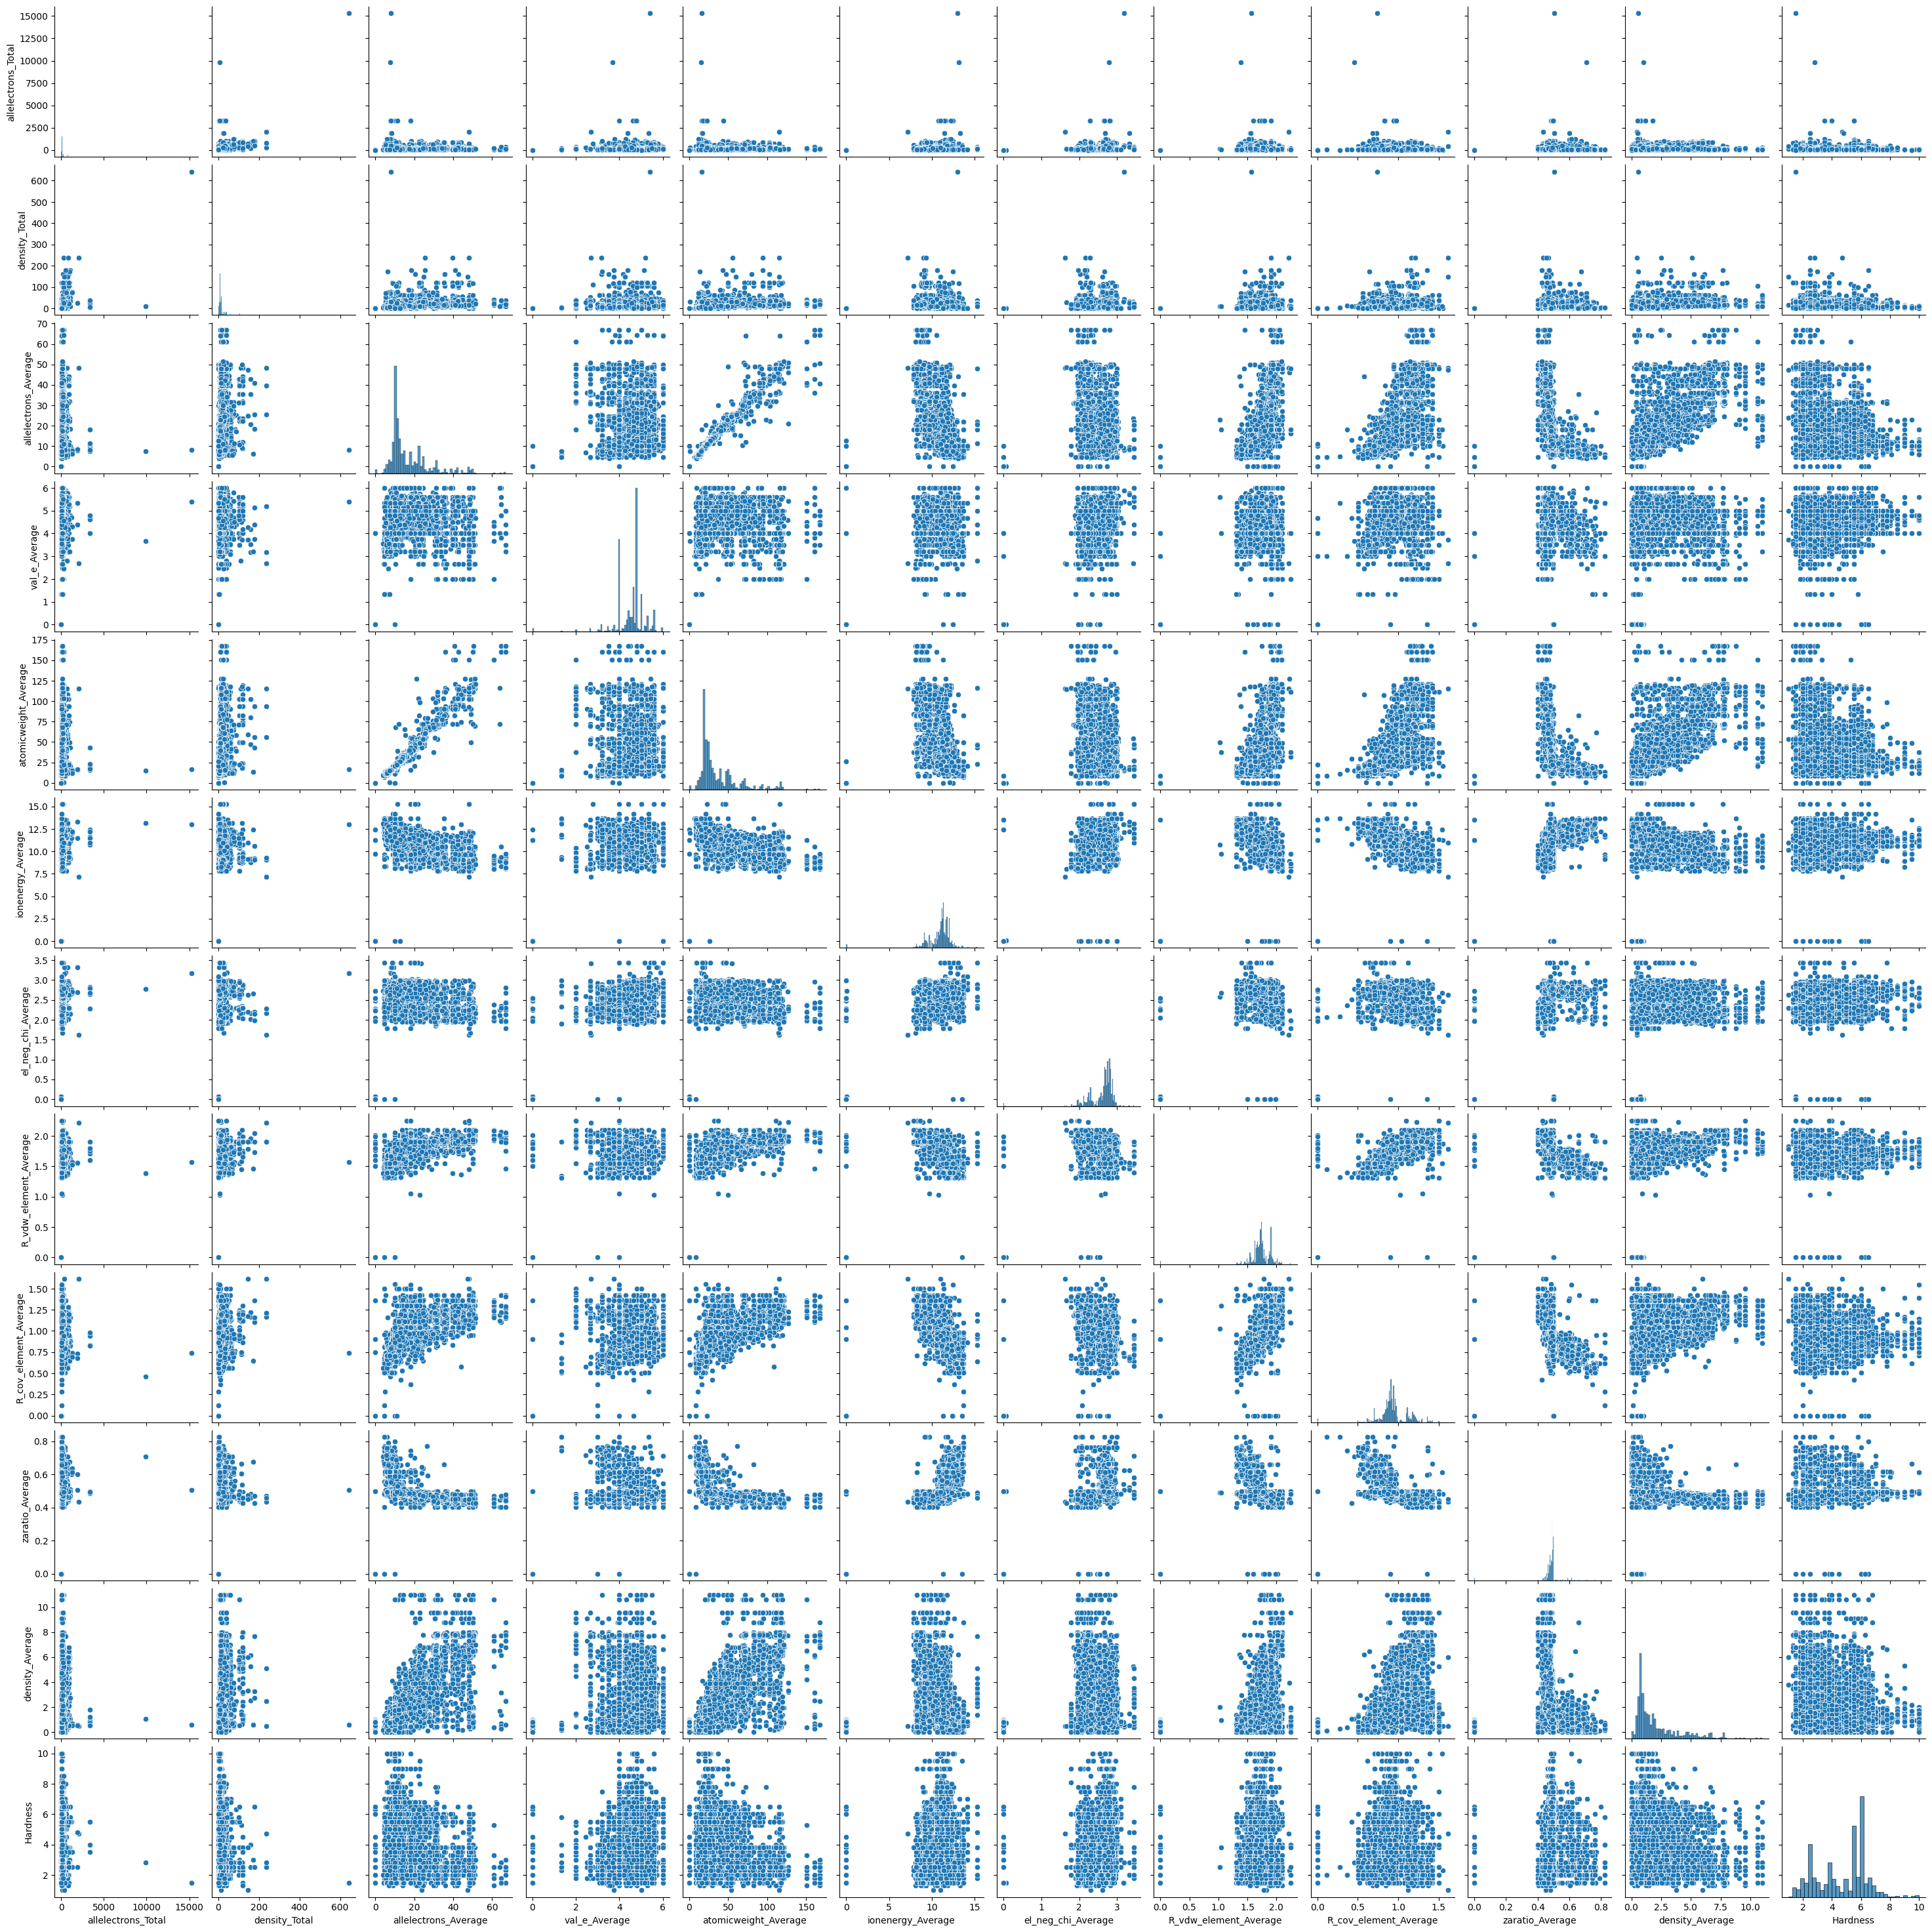

In [15]:
sns.pairplot(df)

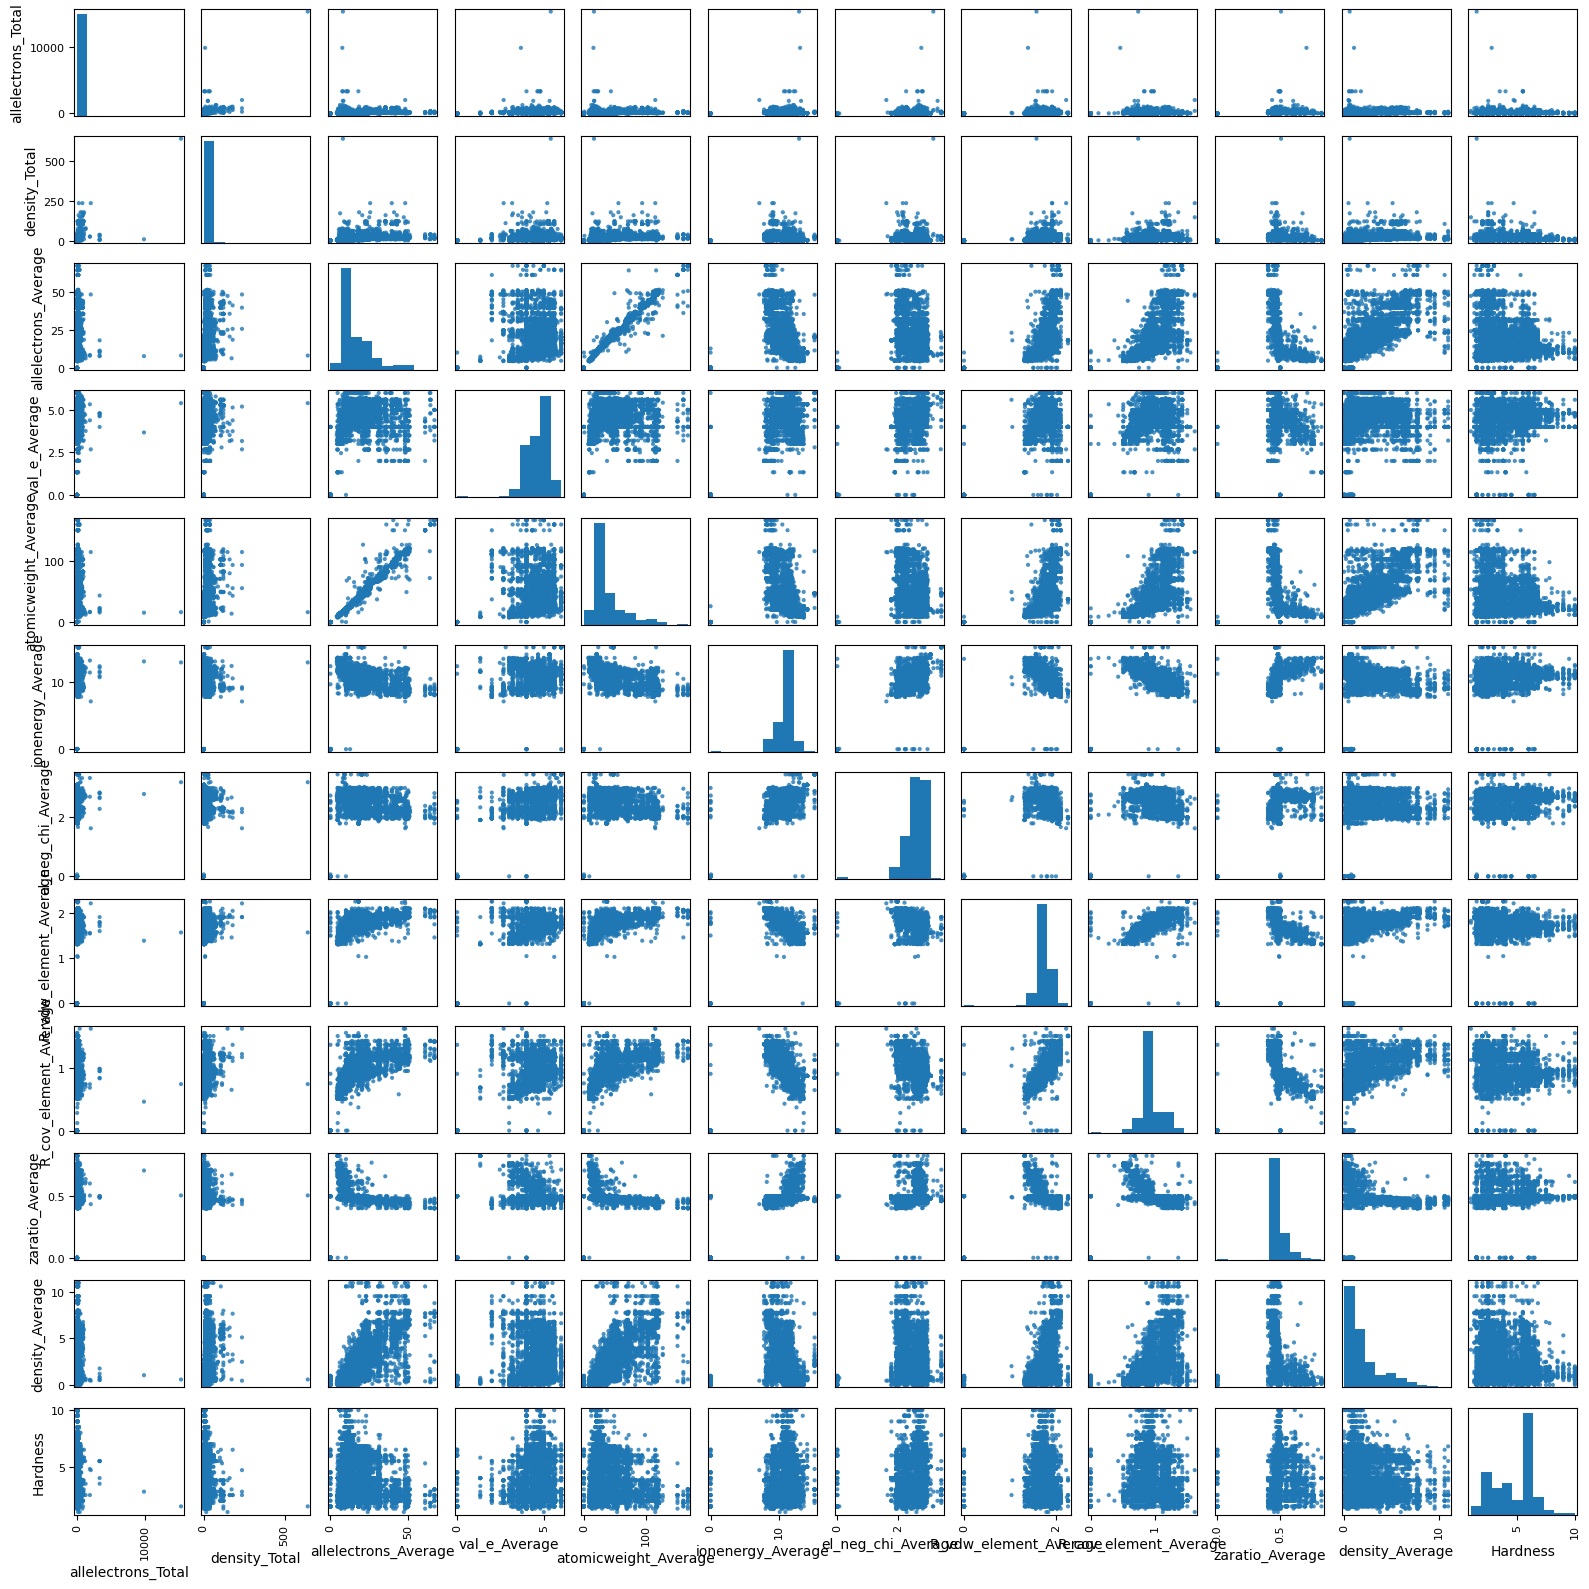

In [16]:
scatter_matrix (df, alpha=0.8, figsize=(16,16)) 
plt.tight_layout()
plt.show()

## Dealing with Outliers




Outliers are data points that significantly differ from the majority of the dataset. They should be removed because they can distort statistical analyses and machine learning models, leading to inaccurate results. Removing outliers helps ensure that models better capture the underlying patterns in the majority of the data.

In [17]:
# function to create histogram, Q-Q plot and boxplot

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

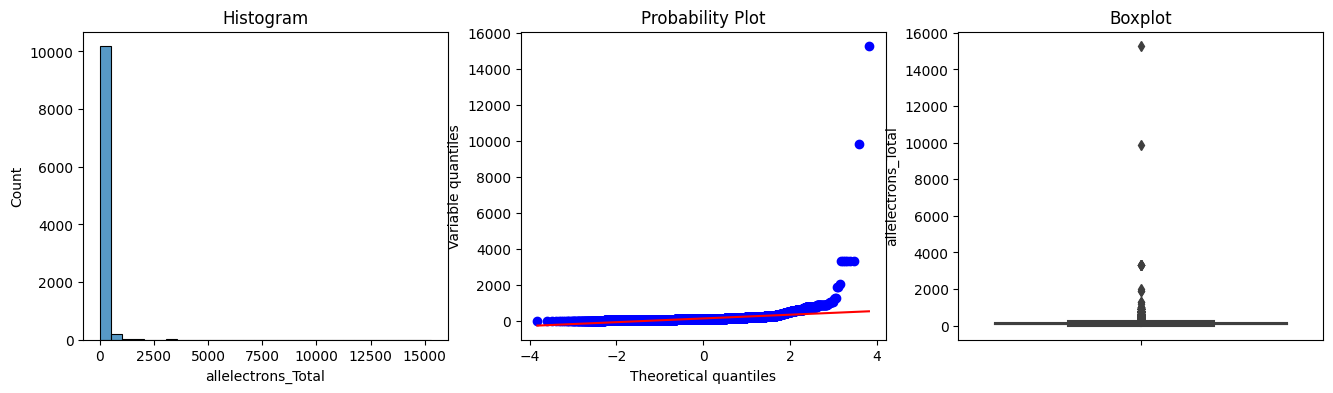

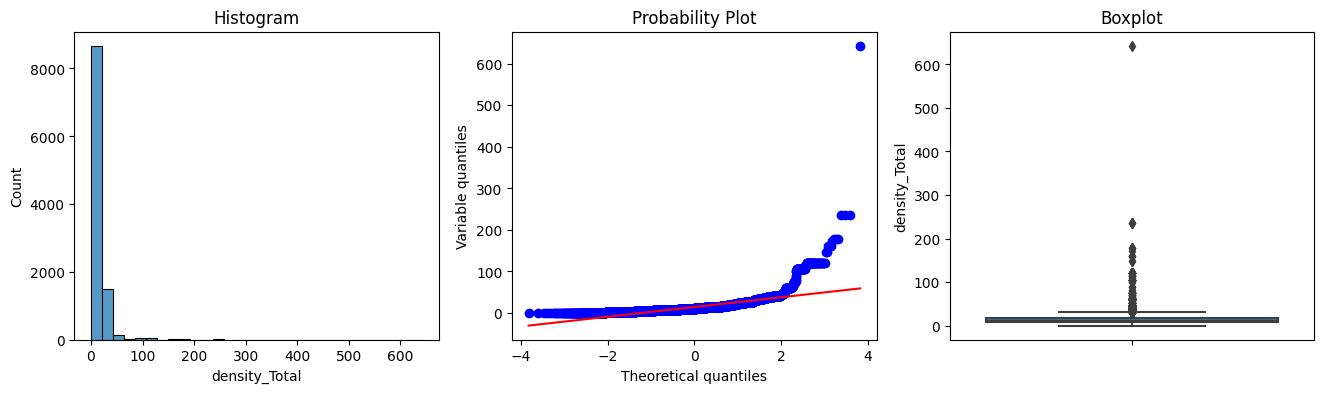

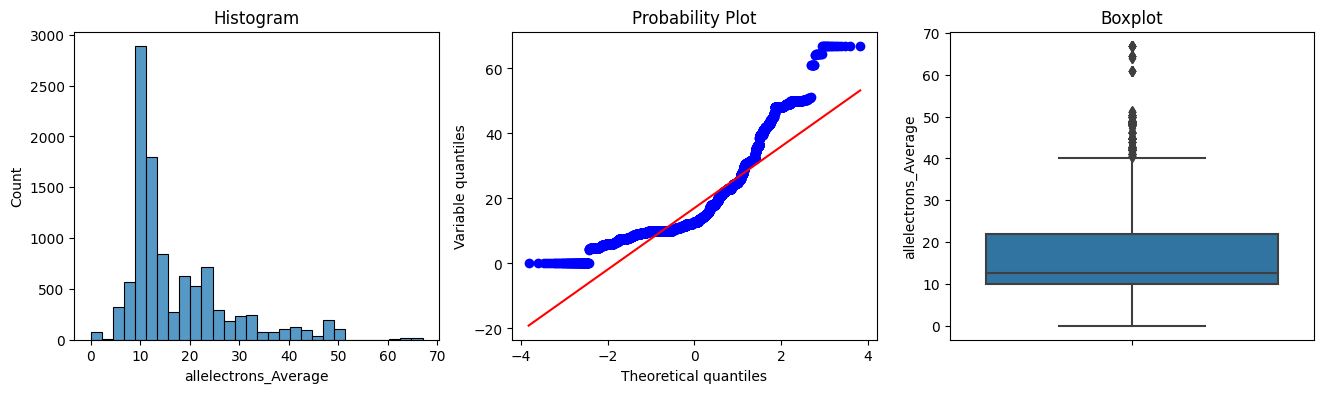

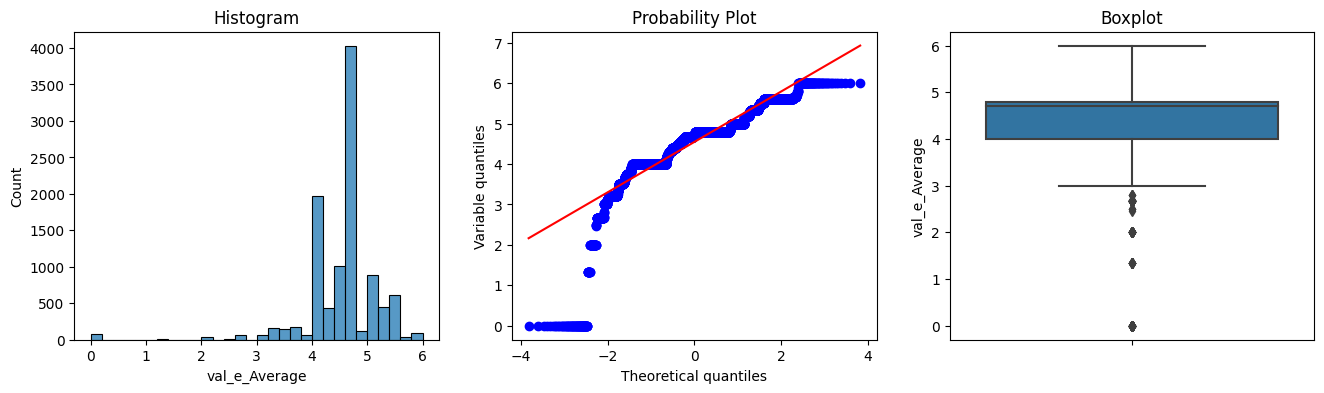

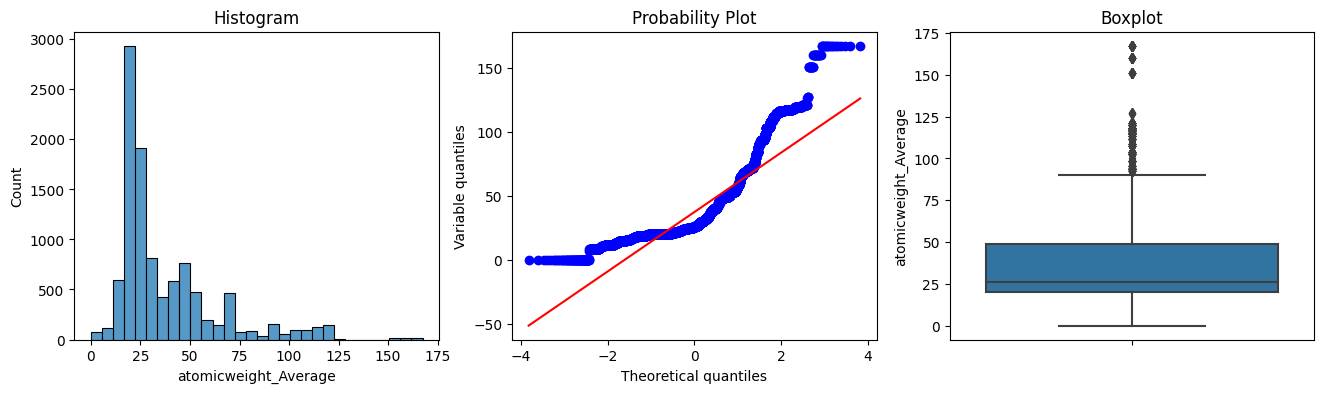

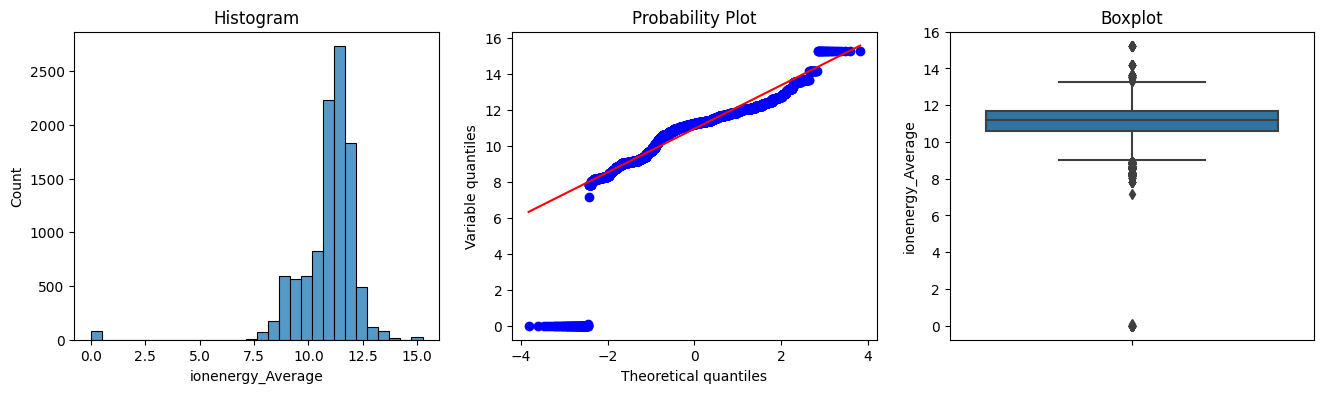

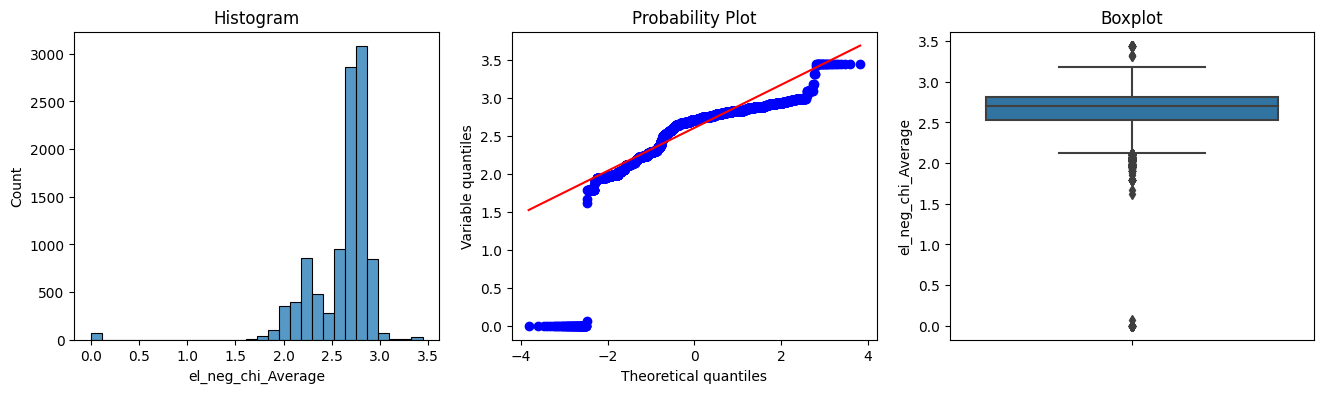

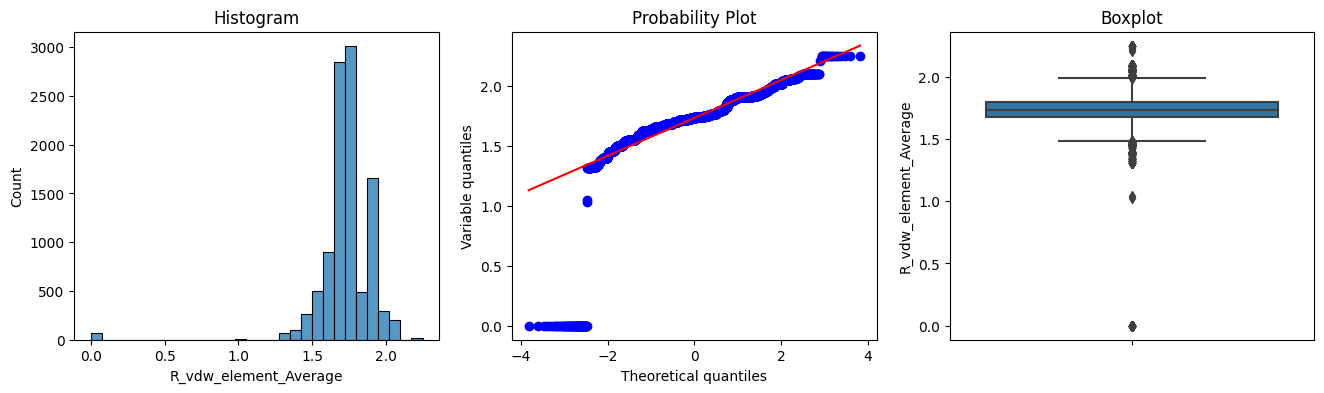

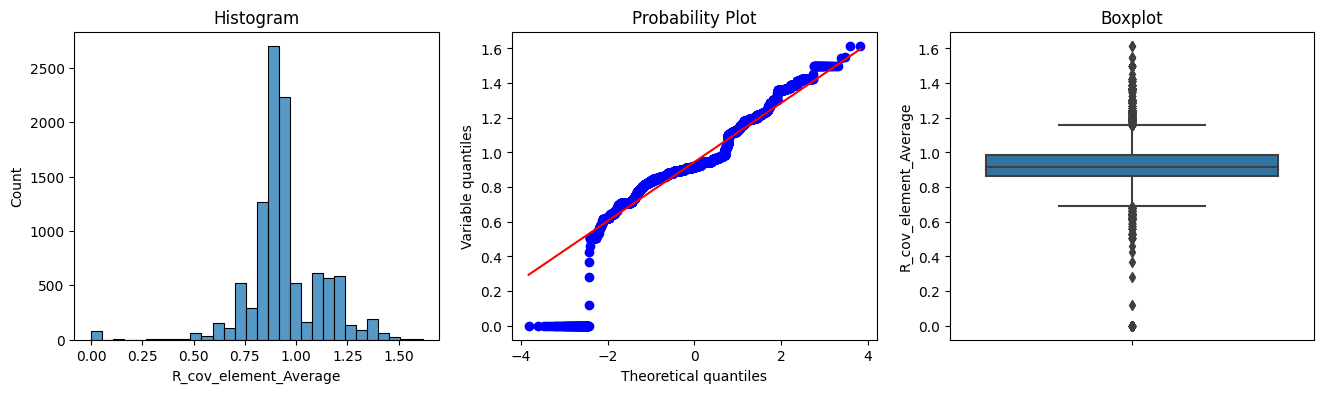

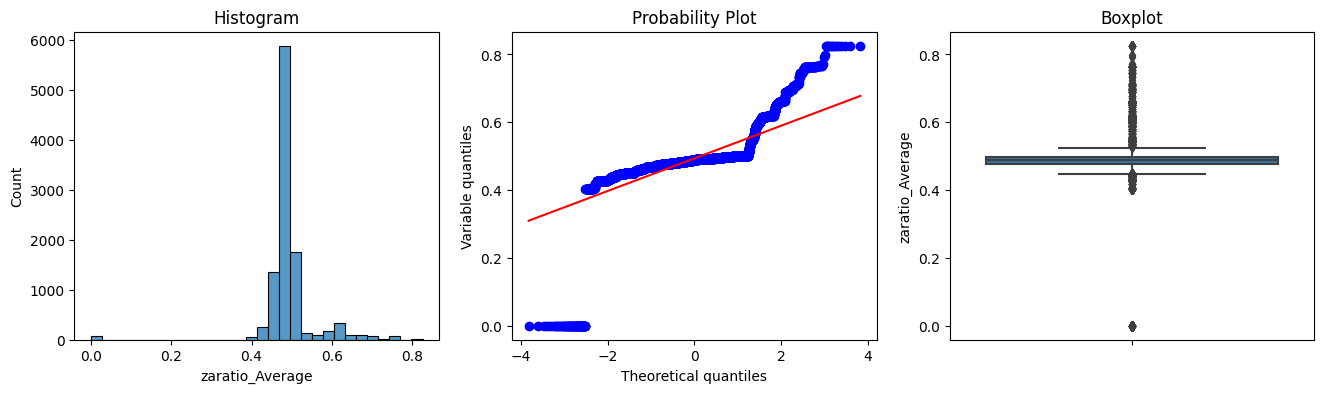

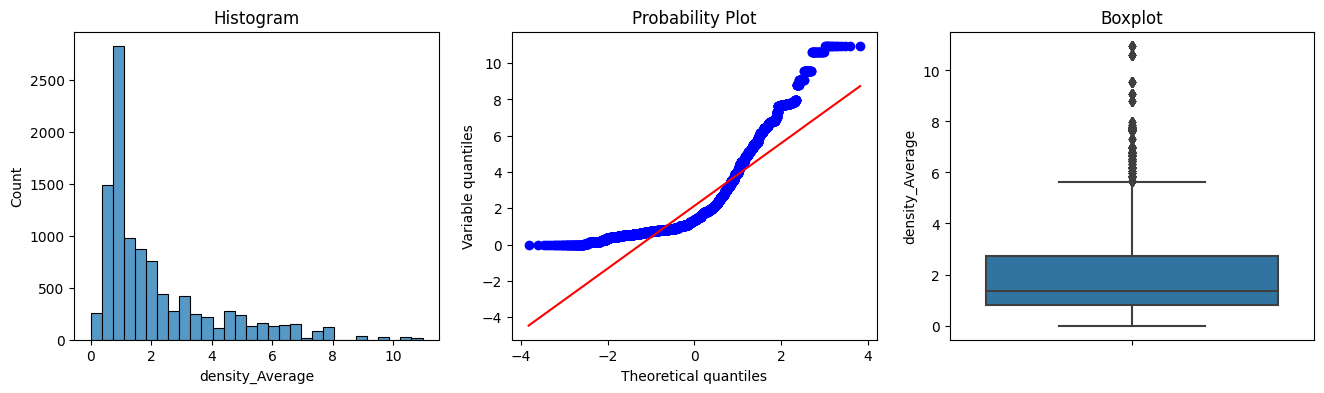

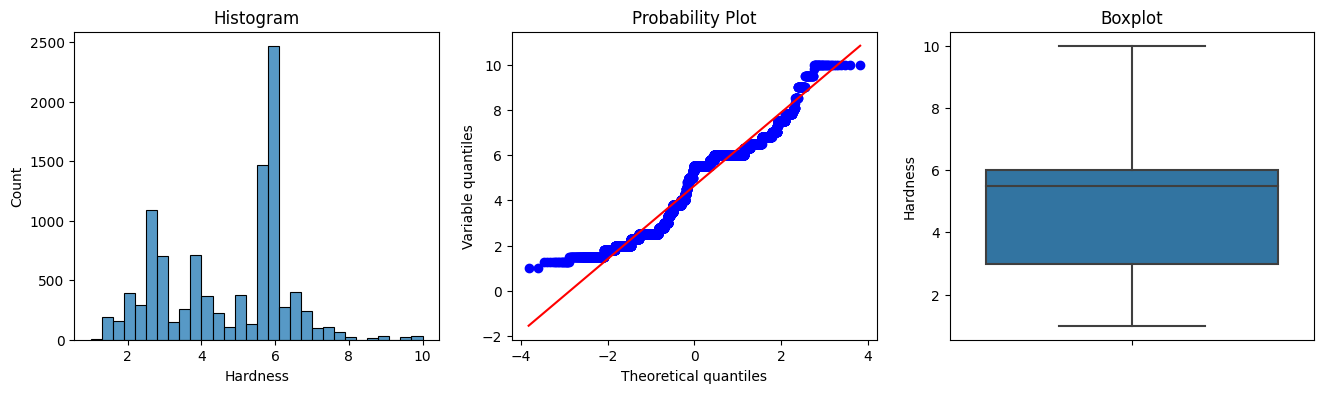

In [18]:
for col in df.columns:
    diagnostic_plots(df, col)
    

From above plots  we can conclude outliers in our data.

In [19]:
#To find the outliers

def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers for skewed distributions
    Q1 = df[variable].quantile(0.25)
    print(f"Q1:{Q1}")
    Q3 = df[variable].quantile(0.75)
    print(f"Q3:{Q3}")

    IQR = Q3 - Q1
    print(f"IQR:{IQR}")
    

    lower_boundary = Q1 - (IQR * distance)
    upper_boundary =  Q3 + (IQR * distance)

    return upper_boundary, lower_boundary

In [20]:
# find limits for allelectrons_Total

allelectrons_Total_upper_limit, allelectrons_Total_lower_limit = find_skewed_boundaries(df, 'allelectrons_Total', 1.5)
allelectrons_Total_upper_limit, allelectrons_Total_lower_limit

Q1:68.0
Q3:131.0
IQR:63.0


(225.5, -26.5)

In [21]:
# find limits for density_Total
density_Total_upper_limit, density_Total_lower_limit = find_skewed_boundaries(df, 'density_Total', 1.5)
density_Total_upper_limit, density_Total_lower_limit

Q1:7.558488000000001
Q3:16.676996
IQR:9.118507999999999


(30.354757999999997, -6.119273999999996)

In [22]:
# find limits for allelectrons_Average
allelectrons_Average_upper_limit, allelectrons_Average_lower_limit = find_skewed_boundaries(df, 'allelectrons_Average', 1.5)
allelectrons_Average_upper_limit, allelectrons_Average_lower_limit

Q1:10.0
Q3:22.0
IQR:12.0


(40.0, -8.0)

In [23]:
# find limits for val_e_Average

val_e_Average_upper_limit, val_e_Average_lower_limit = find_skewed_boundaries(df, 'val_e_Average', 1.5)
val_e_Average_upper_limit, val_e_Average_lower_limit

Q1:4.0
Q3:4.8
IQR:0.7999999999999998


(6.0, 2.8000000000000003)

In [24]:
# find limits for atomicweight_Average

atomicweight_Average_upper_limit, atomicweight_Average_lower_limit = find_skewed_boundaries(df, 'atomicweight_Average', 1.5)
atomicweight_Average_upper_limit, atomicweight_Average_lower_limit

Q1:20.2988926326
Q3:48.7195
IQR:28.420607367399995


(91.3504110511, -22.33201841849999)

In [25]:
# find limits for ionenergy_Average

ionenergy_Average_upper_limit, ionenergy_Average_lower_limit = find_skewed_boundaries(df, 'ionenergy_Average', 1.5)
ionenergy_Average_upper_limit, ionenergy_Average_lower_limit

Q1:10.59066
Q3:11.670725000000001
IQR:1.0800650000000012


(13.290822500000003, 8.970562499999998)

In [26]:
# find limits for el_neg_chi_Average

el_neg_chi_Average_upper_limit, el_neg_chi_Average_lower_limit = find_skewed_boundaries(df, 'el_neg_chi_Average', 1.5)
el_neg_chi_Average_upper_limit, el_neg_chi_Average_lower_limit

Q1:2.53
Q3:2.805
IQR:0.27500000000000036


(3.2175000000000007, 2.1174999999999993)

In [27]:
# find limits for R_vdw_element_Average

R_vdw_element_Average_upper_limit, R_vdw_element_Average_lower_limit = find_skewed_boundaries(df, 'R_vdw_element_Average', 1.5)
R_vdw_element_Average_upper_limit, R_vdw_element_Average_lower_limit

Q1:1.6725
Q3:1.8000000000000005
IQR:0.1275000000000004


(1.991250000000001, 1.4812499999999995)

In [28]:
# find limits for R_cov_element_Average

R_cov_element_Average_upper_limit, R_cov_element_Average_lower_limit = find_skewed_boundaries(df, 'R_cov_element_Average', 1.5)
R_cov_element_Average_upper_limit, R_cov_element_Average_lower_limit

Q1:0.8640000000000001
Q3:0.9816666666666668
IQR:0.1176666666666667


(1.1581666666666668, 0.6875)

In [29]:
# find limits for zaratio_Average

zaratio_Average_upper_limit, zaratio_Average_lower_limit = find_skewed_boundaries(df, 'zaratio_Average', 1.5)
zaratio_Average_upper_limit, zaratio_Average_lower_limit

Q1:0.476196
Q3:0.4960699999999999
IQR:0.019873999999999892


(0.5258809999999997, 0.44638500000000014)

In [30]:
# find limits for density_Average

density_Average_upper_limit, density_Average_lower_limit = find_skewed_boundaries(df, 'density_Average', 1.5)
density_Average_upper_limit, density_Average_lower_limit

Q1:0.8148
Q3:2.74155
IQR:1.9267500000000002


(5.631675, -2.0753250000000003)

In [31]:
#let's mark the outliers in the dataset
outliers_allelectrons_Total = np.where(df['allelectrons_Total'] > allelectrons_Total_upper_limit, True,
                       np.where(df['allelectrons_Total'] < allelectrons_Total_lower_limit, True, False))

In [32]:
outliers_density_Total = np.where(df['density_Total'] > density_Total_upper_limit, True,
                       np.where(df['density_Total'] < density_Total_lower_limit, True, False))

In [33]:
outliers_allelectrons_Average = np.where(df['allelectrons_Average'] > allelectrons_Average_upper_limit, True,
                       np.where(df['allelectrons_Average'] < allelectrons_Average_lower_limit, True, False))

In [34]:
outliers_val_e_Average = np.where(df['val_e_Average'] > val_e_Average_upper_limit, True,
                       np.where(df['val_e_Average'] < val_e_Average_lower_limit, True, False))

In [35]:
outliers_atomicweight_Average = np.where(df['atomicweight_Average'] > atomicweight_Average_upper_limit, True,
                       np.where(df['atomicweight_Average'] < atomicweight_Average_lower_limit, True, False))

In [36]:
outliers_ionenergy_Average = np.where(df['ionenergy_Average'] > ionenergy_Average_upper_limit, True,
                       np.where(df['ionenergy_Average'] < ionenergy_Average_lower_limit, True, False))

In [37]:
outliers_el_neg_chi_Average = np.where(df['el_neg_chi_Average'] > el_neg_chi_Average_upper_limit, True,
                       np.where(df['el_neg_chi_Average'] < el_neg_chi_Average_lower_limit, True, False))

In [38]:
outliers_R_vdw_element_Average = np.where(df['R_vdw_element_Average'] > R_vdw_element_Average_upper_limit, True,
                       np.where(df['R_vdw_element_Average'] < R_vdw_element_Average_lower_limit, True, False))

In [39]:
outliers_R_cov_element_Average = np.where(df['R_cov_element_Average'] > R_cov_element_Average_upper_limit, True,
                       np.where(df['R_cov_element_Average'] < R_cov_element_Average_lower_limit, True, False))

In [40]:
outliers_zaratio_Average = np.where(df['zaratio_Average'] > zaratio_Average_upper_limit, True,
                       np.where(df['zaratio_Average'] < zaratio_Average_lower_limit, True, False))

In [41]:
outliers_density_Average = np.where(df['density_Average'] > density_Average_upper_limit, True,
                       np.where(df['density_Average'] < density_Average_lower_limit, True, False))

In [42]:
# Trimming outlier from the dataset

In [43]:


df_trimmed = df.loc[~(outliers_allelectrons_Total + outliers_density_Total + outliers_allelectrons_Average+outliers_val_e_Average+outliers_atomicweight_Average+outliers_ionenergy_Average+outliers_el_neg_chi_Average+outliers_R_vdw_element_Average+outliers_R_cov_element_Average+outliers_zaratio_Average+outliers_density_Average), ]

df.shape, df_trimmed.shape

((10407, 12), (6432, 12))

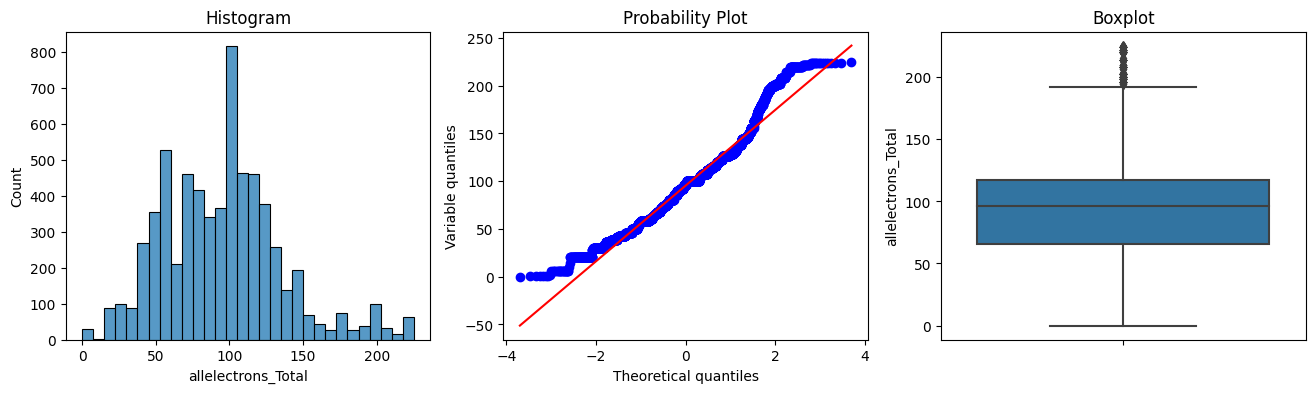

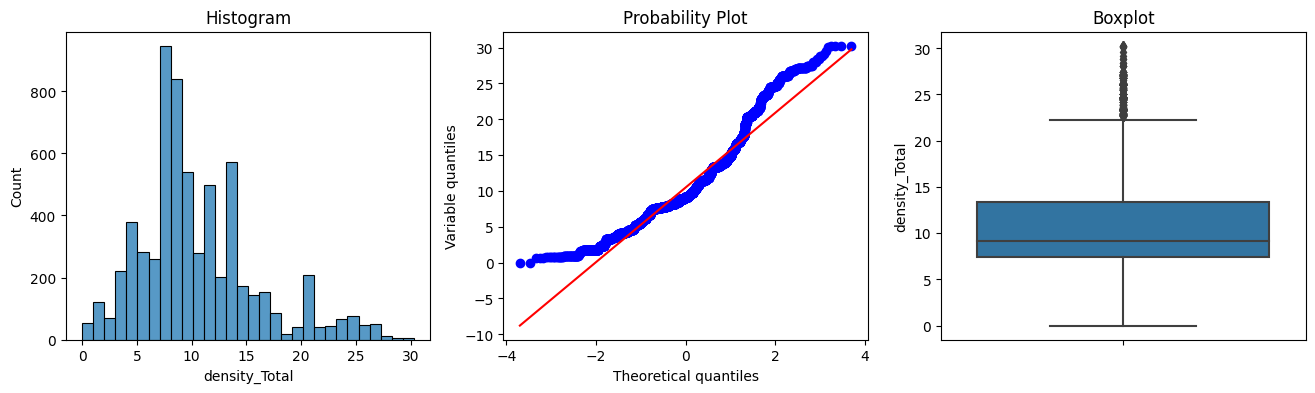

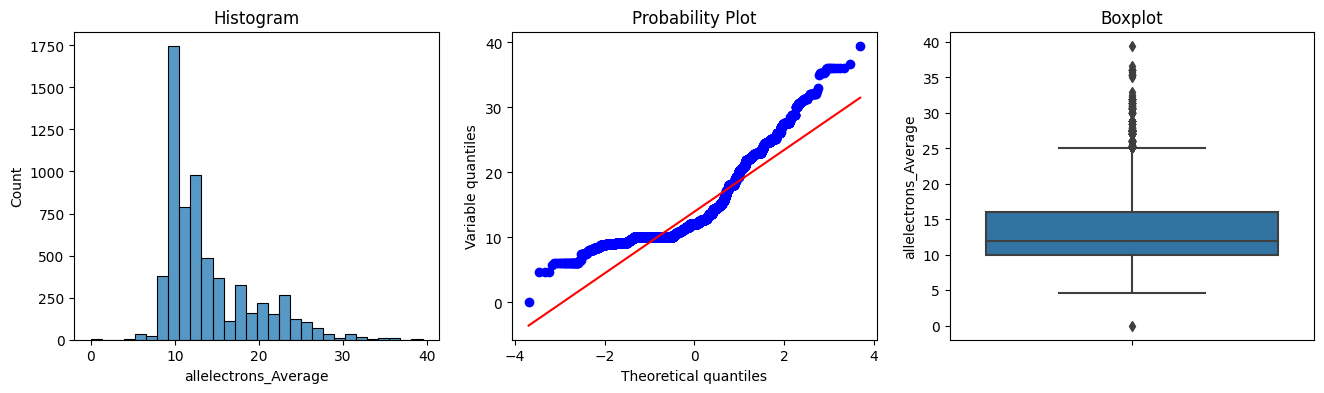

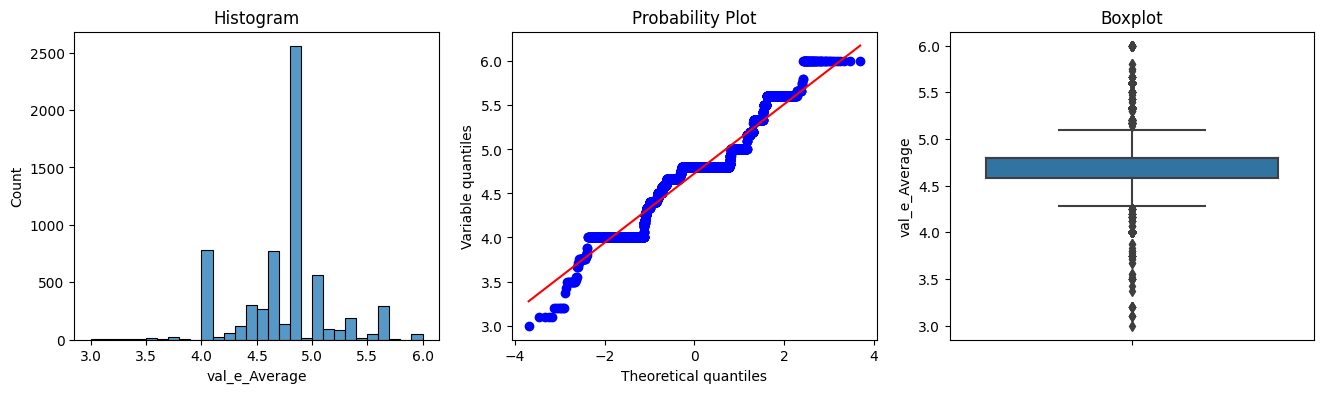

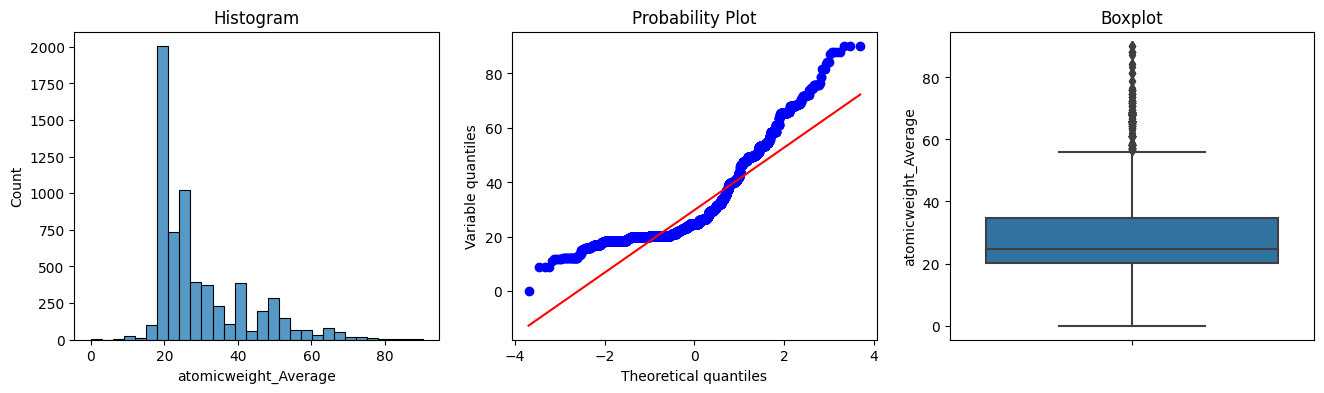

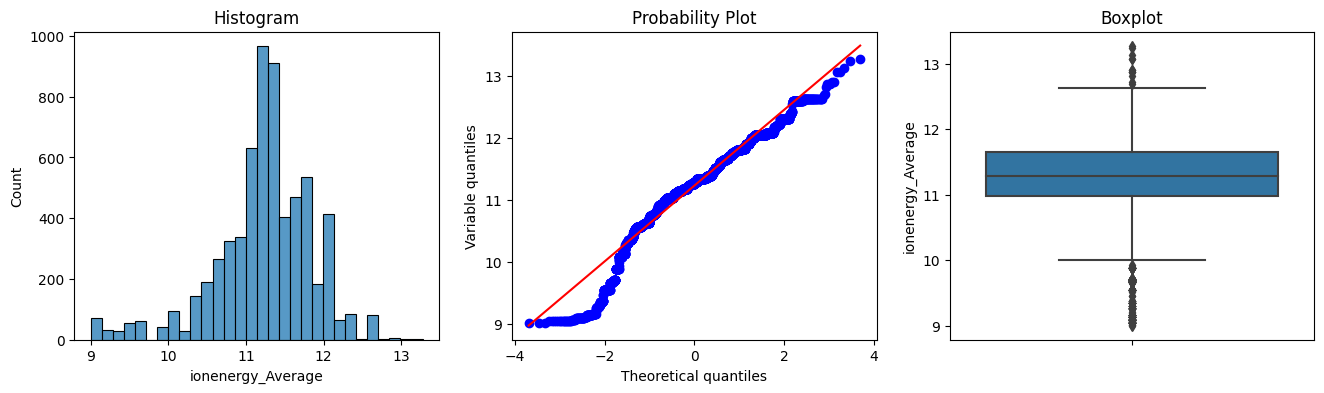

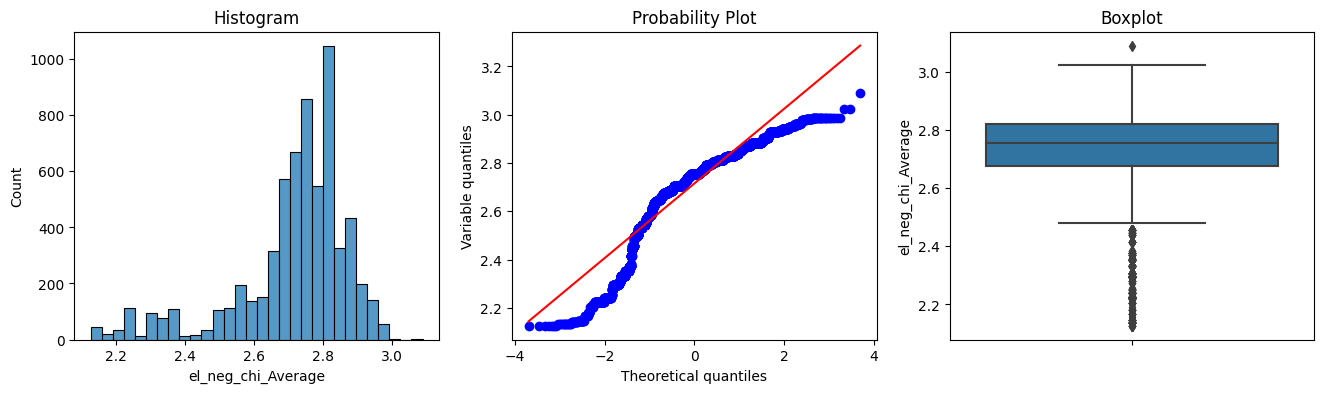

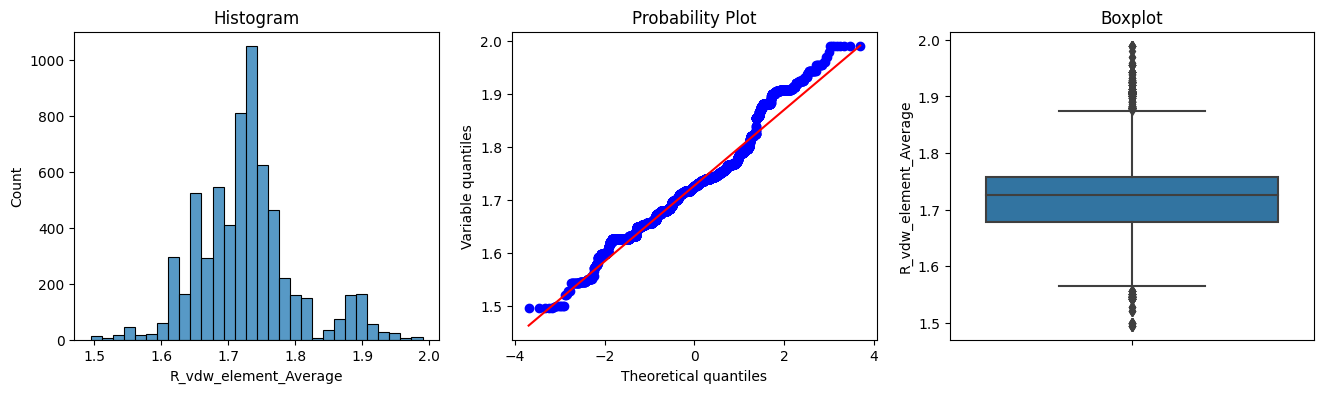

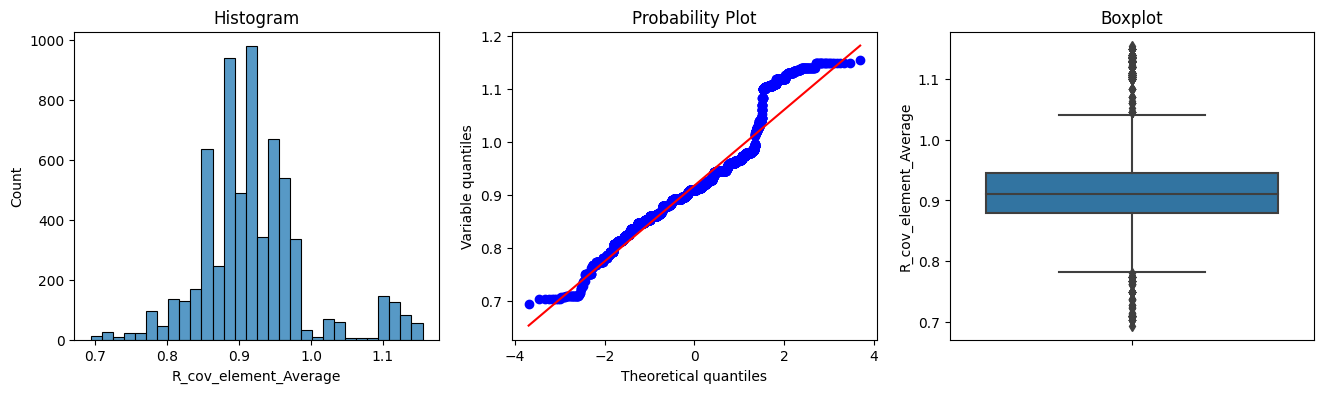

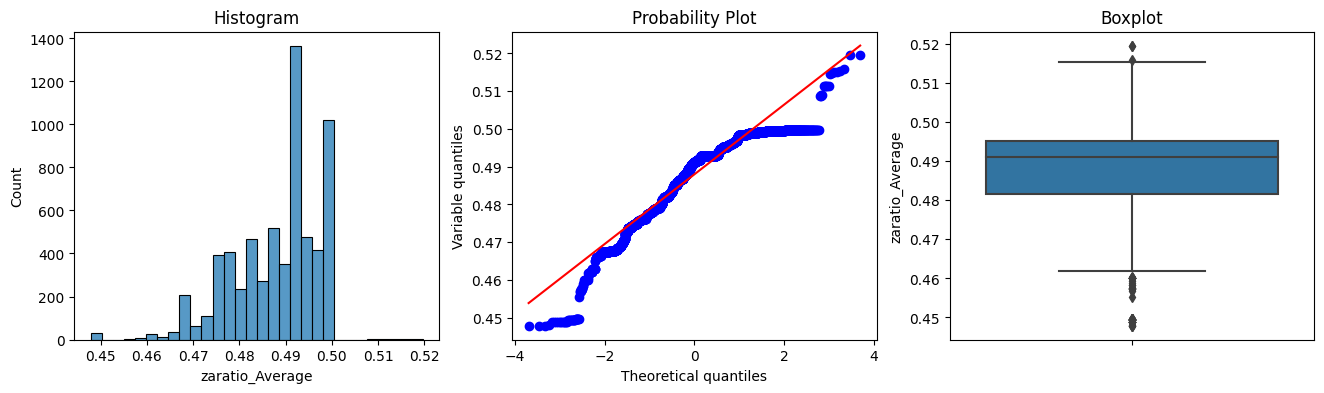

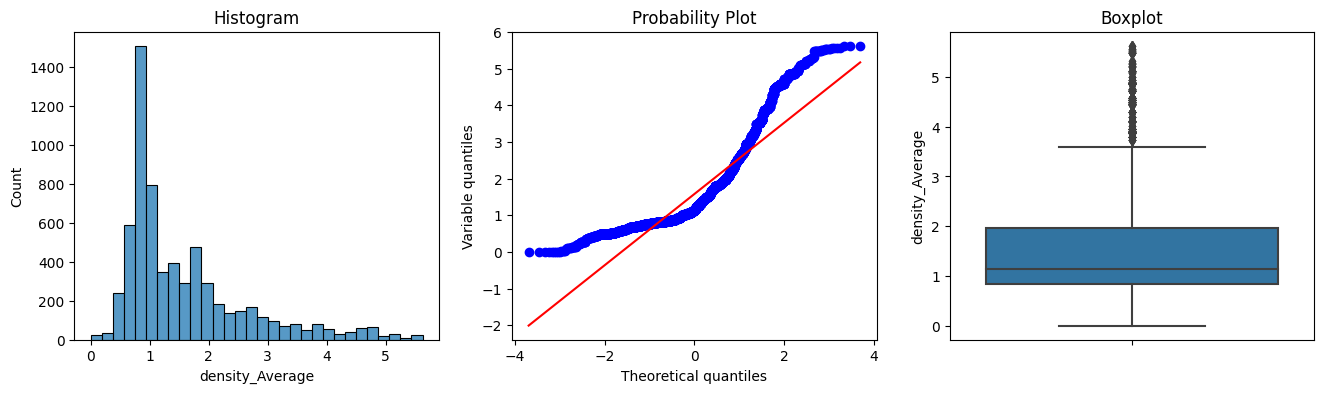

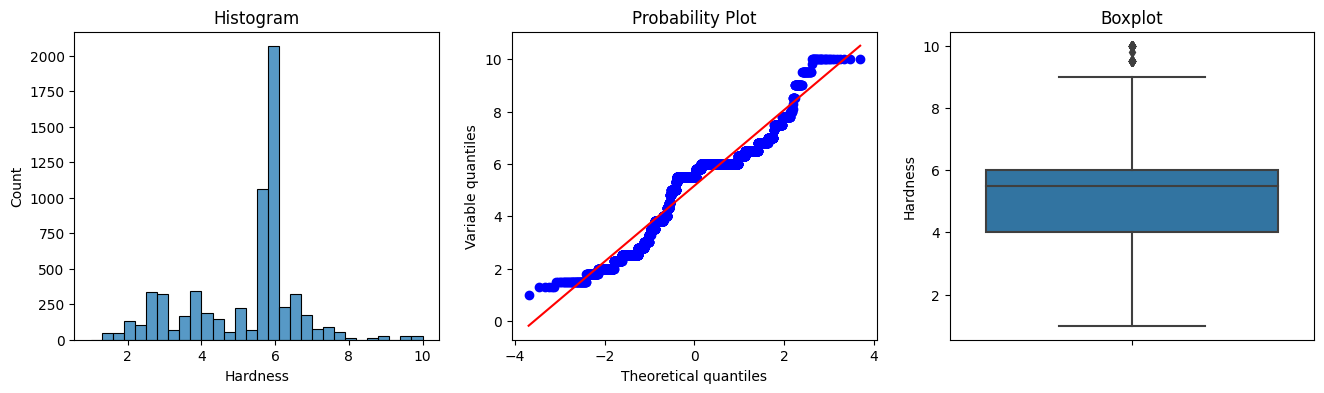

In [44]:
for col in df_trimmed.columns:
    diagnostic_plots(df_trimmed, col)
    

In [45]:
df1 = df_trimmed.copy()

In [46]:
df1.head()

allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
0               100.0       0.841611                  10.0            4.8   
1               100.0       7.558488                  10.0            4.8   
2                76.0       8.885992                  15.6            5.6   
3               100.0       8.795296                  10.0            4.8   
4               116.0       9.577996                  11.6            4.8   

   atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
0             20.612526           11.08810               2.766   
1             20.298893           12.04083               2.755   
2             33.739258           12.08630               2.828   
3             20.213349           10.94850               2.648   
4             24.988133           11.82448               2.766   

   R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
0                  1.732                  0.860         0.496070   
1                  1.631                  0.910         0.492719   
2                  1.788                  0.864         0.481478   
3                  1.626                  0.936         0.489272   
4                  1.682                  0.896         0.492736   

   density_Average  Hardness  
0          0.91457       6.0  
1          0.71760       6.5  
2          1.50633       2.5  
3          0.78937       6.0  
4          1.86481       6.0

## Separating Features and Depedent variable of dataset

In [47]:
X = df1.drop("Hardness", axis=1)
y = df1["Hardness"]

In [48]:
X.isnull().sum()

allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
dtype: int64

In [49]:
y.isnull().sum()

0

In [50]:
X.shape

(6432, 11)

In [51]:
y.shape

(6432,)

## Splitting the dataset into the Training set and Test set

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

##  Feature Scaling

The scaling method used here is called Standard Scaling or Z-score normalization, and it is implemented with the StandardScaler from scikit-learn. This scaling method standardizes the features by transforming them in a way that they have a mean of 0 and a standard deviation of 1. The purpose of standard scaling is to bring all features to a common scale, which can be particularly important for machine learning algorithms that are sensitive to the scale of the input features. Standardized features prevent certain features from dominating others in terms of their influence on the model.

In [53]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [54]:
X_train_scaled

array([[ 0.61173581,  0.59875825, -0.38828921, ..., -0.1106575 ,
         0.50406895, -0.16510443],
       [-0.5351027 ,  0.78145991,  2.05489078, ...,  0.85888786,
        -1.88697894,  2.35241764],
       [-1.4326285 , -1.10667455, -0.26054124, ...,  0.0230729 ,
        -0.1429331 , -0.95172601],
       ...,
       [-0.93400306, -0.98415232, -0.46493799, ...,  0.34402584,
        -0.91533335, -0.93631373],
       [-0.5351027 ,  0.80922098,  0.14825228, ..., -0.24438789,
        -0.60727341, -0.29013271],
       [-0.68469034, -0.29879174, -0.19666725, ...,  0.35739888,
         0.16651169,  0.25484069]])

## Building Model

In [55]:
# Creating an instance of LGBMRegressor
lgb_model = lgb.LGBMRegressor()

# Defining a custom scorer for median absolute error
median_absolute_error_scorer = make_scorer(median_absolute_error, greater_is_better=False)

# Perform cross-validation
cv_scores = cross_val_score(lgb_model, X_train_scaled, y_train, cv=5, scoring=median_absolute_error_scorer)

# Convert scores from negative to positive
cv_mae_scores = -cv_scores

# Print the cross-validated median absolute error for each fold
for fold, mae_score in enumerate(cv_mae_scores, 1):
    print(f'Fold {fold} - Median Absolute Error: {mae_score}')

Fold 1 - Median Absolute Error: 0.582797718422281
Fold 2 - Median Absolute Error: 0.6234605123639074
Fold 3 - Median Absolute Error: 0.5968222273008204
Fold 4 - Median Absolute Error: 0.6294064261054384
Fold 5 - Median Absolute Error: 0.6630139087678426


## Evalution Metrics

In [56]:
print(f'Mean MAE across 5-folds: {cv_mae_scores.mean()}')

Mean MAE across 5-folds: 0.6191001585920579


## Predictions on Test data

In [57]:
test_df.head(2)

id  allelectrons_Total  density_Total  allelectrons_Average  \
0  10407               884.0      121.42000                 35.36   
1  10408                90.0        9.93196                 18.00   

   val_e_Average  atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
0           5.28             82.561240           9.370384               2.298   
1           5.60             39.568056          12.086300               2.868   

   R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
0                 1.9072                  1.200         0.461899   
1                 1.6520                  0.864         0.476196   

   density_Average  
0          1.79459  
1          1.41194

In [58]:
test_df.shape

(6939, 12)

In [59]:
test =test_df.drop("id", axis=1)

In [60]:
#apply scalling to test data
test_s = sc.transform(test)

In [61]:
# Create an instance of LGBMRegressor
lgb_model = lgb.LGBMRegressor()

# Train the model on the scaled training data
lgb_model.fit(X_train_scaled, y_train)

# Now, you can make predictions on the unknown data
lgb_predictions_test_s = lgb_model.predict(test_s)

# Printing the predictions as needed
print("Predictions on Unknown Test_s data:", lgb_predictions_test_s)


Predictions on Unknown Test_s data: [3.16570824 2.58974333 5.96826989 ... 4.958087   3.15117819 2.86184685]


In [62]:
submission = pd.DataFrame({'id': test_df.id, 'Hardness': np.round(lgb_predictions_test_s, 3)})
print(submission.shape)
submission.head()

(6939, 2)


id  Hardness
0  10407     3.166
1  10408     2.590
2  10409     5.968
3  10410     4.861
4  10411     5.203

## Saving Submission file

In [63]:
submission.to_csv('sample_submission.csv', index=False)

## Thank you!